<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Installazione librerie e setup ambiente

In [1]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time


In [3]:
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Userai:", device)

GPU disponibile: []
Userai: cpu


Collegamento al drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [6]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [8]:
%ls /content/drive/MyDrive/HumanData/ESC-10/


chainsaw/    crackling_fire/  dog/         rain/     sea_waves/
clock_tick/  crying_baby/     helicopter/  rooster/  sneezing/


## Processare tutti i file audio di ESC10

In [7]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100  # non fare downsampling
DURATION = 5.0       # lunghezza standard (secondi)
BATCH_SIZE = 32

class ESCLabels(Enum):
    chainsaw = 0
    clock_tick = 1
    crackling_fire = 2
    crying_baby = 3
    dog = 4
    helicopter = 5
    rain = 6
    rooster = 7
    sea_waves = 8
    sneezing = 9

- Se un audio ha una frequenza di campionamento di 44.1 kHz, significa che ogni secondo è rappresentato da 44.100 campioni (numeri). Più alta è la frequenza, più dettagliato sarà il suono (fino a un certo limite). 44.1 kHz è sufficiente per rappresentare tutte le frequenze udibili dall’orecchio umano (fino a ~20 kHz), secondo il teorema di Nyquist.

- Trim + Normalizzazione: rimuovo silenzio per non sprecare tempo computazionale su dati inutili. Scalare il segnale in [-1,1] in modo da rimuovere il bias di ampiezza tra clip (evita che la rete impari "volume=classe")

- Con la normalizzazione vado a modificare il range dell'ampiezza, cioè quanto forte o debole è il segnale

per ora non trimmo i silenzio --> possibile ablation study con e senza trim

Perché NON usare trim:
Mantieni la coerenza temporale tra le clip
→ fondamentale per SNN e spike encoding, che sono sensibili alla sequenza temporale dei pattern.

Eviti disallineamenti introdotti da librosa.effects.trim
→ anche 0.2 secondi di shift possono alterare l’input percepito dal modello.

Se usi segmenti (chunk) fissi via timesteps=50,
→ i segmenti devono sempre partire dallo stesso punto temporale.

In [9]:
def load_audio_file(file_path, sr=44100, duration=5.0, top_db = 30):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    #y, _ = librosa.effects.trim(y, top_db=top_db)           # elimina silence iniziale e finale
    y = librosa.util.normalize(y)           # normalizzazione RMS
    #if len(y) < int(sr * duration):
    #    padding = int(sr * duration) - len(y)
    #    y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

controllo di quanto silenzio toglie

In [10]:
# total_trimmed_start = 0.0
# total_trimmed_end = 0.0
# clip_count = 0

# for label in sorted(os.listdir(BASE_PATH)):
#     class_path = os.path.join(BASE_PATH, label)
#     for file in os.listdir(class_path):
#         if file.endswith(".wav"):
#             file_path = os.path.join(class_path, file)

#             # Carica audio
#             y, sr = librosa.load(file_path, sr=44100, duration=5.0)

#             # Applica trim
#             y_trimmed, index = librosa.effects.trim(y, top_db=30)
#             start_sample, end_sample = index

#             # Converti in secondi
#             start_sec = start_sample / sr
#             end_sec = (len(y) - end_sample) / sr

#             total_trimmed_start += start_sec
#             total_trimmed_end += end_sec
#             clip_count += 1

#             print(f"{file} → Trim: start={start_sec:.2f}s, end={end_sec:.2f}s")

# # Statistiche finali
# print("\n--- STATISTICHE TOTALI ---")
# print(f"Clip analizzati: {clip_count}")
# print(f"Silenzio medio INIZIALE tagliato: {total_trimmed_start / clip_count:.2f} s")
# print(f"Silenzio medio FINALE tagliato: {total_trimmed_end / clip_count:.2f} s")


In [11]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [01:55<00:00, 11.51s/it]


In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.3, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 280, Val: 60, Test: 60


## NAA

In [13]:
def center_crop(signal, target_len):
    if len(signal) < target_len:
        pad_left = (target_len - len(signal)) // 2
        pad_right = target_len - len(signal) - pad_left
        return np.pad(signal, (pad_left, pad_right), mode='constant')
    else:
        start = (len(signal) - target_len) // 2
        return signal[start:start + target_len]


In [14]:
def naa(y, sr):
    augmented = []
    target_len = int(sr * 5.0)

    # Originale
    augmented.append(center_crop(y, target_len))

    # Pitch shift
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2), target_len))
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2), target_len))

    # Time stretch
    for rate in [0.7, 1.2]:
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        augmented.append(center_crop(y_stretched, target_len))

    return augmented

In [15]:
X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))


NAA: 100%|██████████| 280/280 [02:24<00:00,  1.94it/s]


In [16]:
# Calcola le lunghezze di tutti gli audio
lengths = [len(x) for x in X_train_aug]

# Trova il minimo e il massimo
min_len = min(lengths)
max_len = max(lengths)

# Converti in secondi (facoltativo)
min_sec = min_len / SAMPLE_RATE
max_sec = max_len / SAMPLE_RATE

print(f"Audio più corto: {min_len} samples ({min_sec:.2f} s)")
print(f"Audio più lungo: {max_len} samples ({max_sec:.2f} s)")


Audio più corto: 220500 samples (5.00 s)
Audio più lungo: 220500 samples (5.00 s)


## Converti in log-Mel

- power_to_db(..., ref=np.max) normalizza ogni spettrogramma rispetto al suo massimo → rende il contrasto tra le bande più utile per la rete. Misura quanto ogni frequenza è forte rispetto al picco. Ha senso np.max perchè ho già normalizzato l'audio a [-1,1] quindi non hai una loudness assoluta. Per la classificazione di suoni ambientali il pattern spettrale è più importante del volume, voglio che ogni clip sia trattato in modo coerente (garantisce scale relative)

- power_to_db(..., ref=np.max) converte il Mel-spectrogramma da potenza lineare (espressa in unità numeriche) a decibel (scala logaritmica)

- il risultato più intenso avrà valore 0 dB. -80 invece significa “tutto ciò che è almeno 10⁸ volte più debole del valore massimo, consideralo praticamente silenzio”. La scala è negativa perchè stai calcolando il logaritmo del rapporto tra ogni valore del Mel-spect e il valore massimo di quel mel-spect



In [17]:
def preprocess_audio(y, sr=44100, n_mels=64, n_fft=1024, hop_length=512):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


Clipping dei frame troppo silenziosi

In [18]:
def clip_silent_frames(mel, threshold_db=-70.0):
    silent_mask = np.all(mel < threshold_db, axis=0)
    mel[:, silent_mask] = threshold_db  # o np.mean(mel)
    return mel

In [19]:
def batch_logmel(X, sr=44100):
    mel_list = []
    for x in tqdm(X, desc="Log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        mel = clip_silent_frames(mel)
        mel_list.append(mel)
    return mel_list

In [20]:
X_train_mel = batch_logmel(X_train_aug)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)

Log-Mel: 100%|██████████| 60/60 [00:00<00:00, 82.92it/s]


In [21]:
print("Train set:", len(X_train_mel))
print("Val set:", len(X_val_mel))
print("Test set:", len(X_test_mel))

print("Shape primo sample train:", X_train_mel[0].shape)

Train set: 1400
Val set: 60
Test set: 60
Shape primo sample train: (64, 431)


visualizzo logmel spect

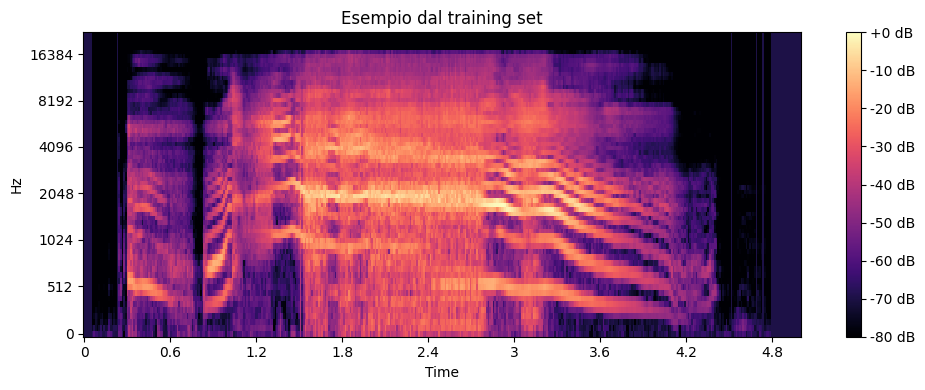

Class:  3


In [22]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualizza un esempio a caso dal training set
show_mel(X_train_mel[0], title="Esempio dal training set")
print("Class: ", y_train_aug[0])


In [23]:
all_vals = np.concatenate([mel.flatten() for mel in X_train_mel])
print("Min:", np.min(all_vals))
print("Max:", np.max(all_vals))

Min: -80.0
Max: 0.0


Padding per uniformare a 450

In [24]:
def pad_to_multiple_of(mel, multiple=50, value=-80.0):
    """
    Pads mel spectrogram along time axis to make time frames a multiple of 'multiple'
    """
    current_len = mel.shape[1]
    target_len = ((current_len + multiple - 1) // multiple) * multiple
    pad_width = target_len - current_len
    return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=value)


In [25]:
# Applica padding a multiplo di 50 (compatibile con timesteps=50)
X_train_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_train_mel]
X_val_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_val_mel]
X_test_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_test_mel]

In [26]:
print("Train shape esempio:", X_train_mel[0].shape)
print("Val shape esempio:", X_val_mel[0].shape)
print("Test shape esempio:", X_test_mel[0].shape)

Train shape esempio: (64, 450)
Val shape esempio: (64, 450)
Test shape esempio: (64, 450)


## DATA AUG TAA

applicare taa dopo normalizzazione perchè imagedatagenerator lavora bene su [0,1]

In [27]:
taa_generator = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.3,
    fill_mode='nearest'
)

In [28]:
X_train_mel_np = np.array(X_train_mel)
X_val_mel_np = np.array(X_val_mel)
X_test_mel_np = np.array(X_test_mel)

if len(X_train_mel_np.shape) == 3:
    X_train_mel_np = X_train_mel_np[..., np.newaxis]  # (N, 64, 431, 1)

y_train_np = np.array(y_train_aug)  # Etichette corrispondenti

### Normalizzazione:
i modelli funzionano meglio con input compresi tra 0 e 1.
0 = silenzio
1 = banda più forte

In [29]:
X_train_mel_np = (X_train_mel_np + 80.0) / 80.0
X_val_mel_np = (X_val_mel_np + 80.0) / 80.0
X_test_mel_np = (X_test_mel_np + 80.0) / 80.0

### TAA

In [30]:
X_taa = []
y_taa = []

augmentations_per_sample = 4  # puoi aumentare questo numero

for i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):
    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)
    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)

    # Genera augmentazioni
    gen = taa_generator.flow(sample, batch_size=1)
    for _ in range(augmentations_per_sample):
        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)
        X_taa.append(aug_sample)
        y_taa.append(y_train_np[i])

# Combina con il training set originale
X_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)
y_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)

print("Nuova shape X:", X_train_augmented.shape)
print("Nuova shape y:", y_train_augmented.shape)

TAA Augmentation: 100%|██████████| 1400/1400 [00:19<00:00, 73.52it/s]


Nuova shape X: (7000, 64, 450, 1)
Nuova shape y: (7000,)


Converto in tensori

In [31]:
X_train = torch.from_numpy(X_train_augmented).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_augmented).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()

In [32]:
print("Shape X_train:", X_train.shape)
print("Tipo dati:", X_train.dtype)
print("Valori min/max:", torch.min(X_train), torch.max(X_train))


Shape X_train: torch.Size([7000, 64, 450, 1])
Tipo dati: torch.float32
Valori min/max: tensor(0.) tensor(1.)


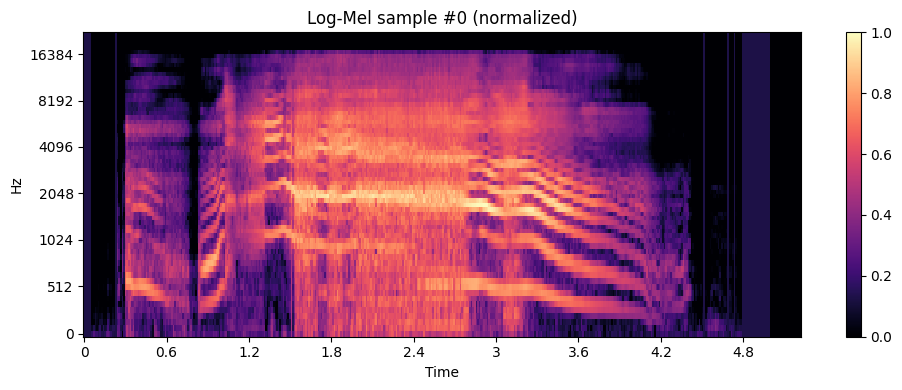

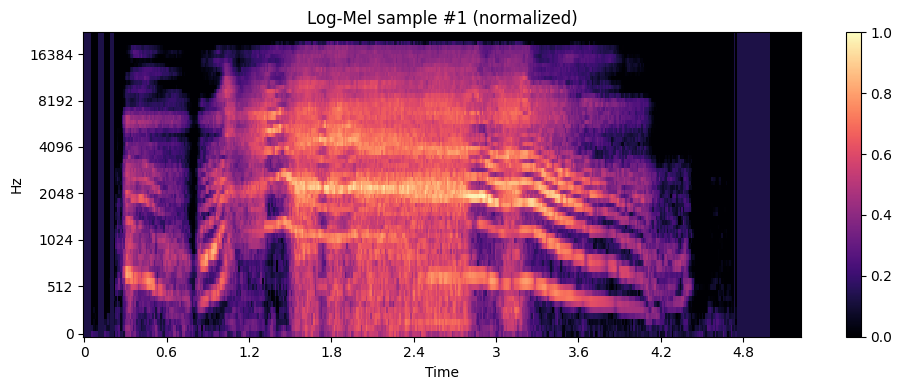

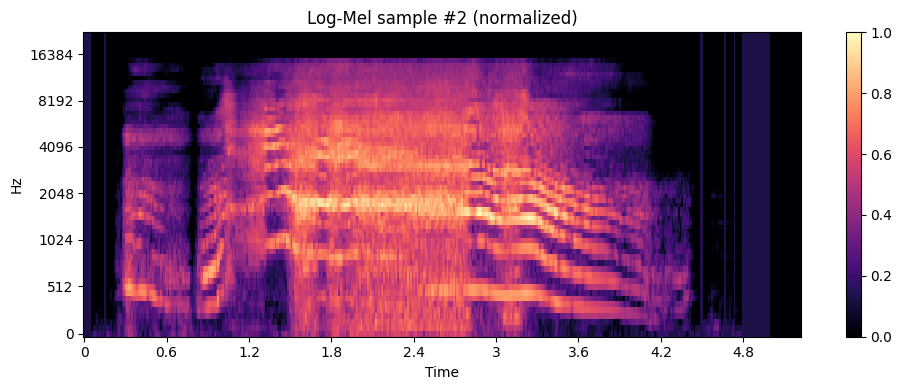

In [33]:
def show_mel_sample(index):
    mel = X_train[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()

for i in range(3):
    show_mel_sample(i)

In [34]:
print("y_train shape:", y_train.shape)
print("Etichette uniche:", np.unique(y_train))

# Stampa etichetta di un esempio
for i in range(3):
    print(f"Esempio {i}: label = {y_train[i]}")


y_train shape: torch.Size([7000])
Etichette uniche: [0 1 2 3 4 5 6 7 8 9]
Esempio 0: label = 3
Esempio 1: label = 3
Esempio 2: label = 3


# Spike Encoding

We define now an helper function to visualize the following ecoded spike trains.

In [35]:
def visualize_spike_trains(spike_tensor, sample_idx=0, mel_bin=10):
    """
    Visualizes delta spike encodings with three plots:
    1. Full raster plot of all mel bins
    2. Single mel bin spike train with vertical lines
    3. Density plot showing balance between positive and negative spikes

    Args:
      spike_tensor : torch.Tensor or list
          The delta spike tensor. Expected shape: [batch_size, time_frames, n_mels]
          If from DataLoader, expected to be a list containing tensors
      sample_idx : int
          Index of the sample in the batch to visualize
      mel_bin : int
          Which mel frequency bin to visualize in the spike train plot
    """

    # Check if input is a list (from DataLoader) or direct tensor
    if isinstance(spike_tensor, list):
        spikes = spike_tensor[0].squeeze(-1)[sample_idx].detach().cpu().numpy()
    elif isinstance(spike_tensor, torch.Tensor):
        # If 4D tensor [batch_size, time_frames, n_mels]
        if len(spike_tensor.shape) == 3:
            spikes = spike_tensor.squeeze(-1)[sample_idx, :, :].detach().cpu().numpy()
        else:
            raise ValueError(f"Unexpected spike tensor shape: {spike_tensor.shape}")
    else:
        raise TypeError("spike_tensor must be a torch.Tensor or a list containing tensors")

    if len(spikes.shape) > 2:
        spikes = spikes.squeeze()

    pos_spikes = (spikes > 0).astype(float)
    neg_spikes = (spikes < 0).astype(float)

    plt.figure(figsize=(10, 12))

    # 1. Raster Plot with Inverted Y-axis
    plt.subplot(3, 1, 1)
    plt.imshow(spikes.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
    plt.colorbar(ticks=[-1, 0, 1], label='Spike Type')
    plt.title("Full Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Bin")
    num_mel_bins = spikes.shape[1]
    tick_interval = max(1, num_mel_bins // 7)
    plt.yticks(np.arange(0, num_mel_bins, tick_interval))

    # 2. Single Mel Bin Spike Train with vlines
    plt.subplot(3, 1, 2)
    pos_times = np.where(spikes[:, mel_bin] == 1)[0]
    neg_times = np.where(spikes[:, mel_bin] == -1)[0]
    plt.vlines(pos_times, 0, 1, color='red', linewidth=0.8)
    plt.vlines(neg_times, -1, 0, color='blue', linewidth=0.8)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    plt.title(f"Spike Train for Mel Bin {mel_bin}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike Value")
    plt.grid(False)
    legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Positive Spikes'),
                      plt.Line2D([0], [0], color='blue', lw=2, label='Negative Spikes')]
    plt.legend(handles=legend_elements)

    # 3. Density Plot with Legend
    plt.subplot(3, 1, 3)
    plt.stackplot(np.arange(spikes.shape[0]),
                  pos_spikes.sum(axis=1),
                  -neg_spikes.sum(axis=1),
                  colors=['red', 'blue'])

    plt.legend(['Positive Spikes', 'Negative Spikes'])
    plt.title("Spike Polarity Balance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Spike Count")

    plt.tight_layout()
    plt.show()

## Delta Modulation

Delta modulation converts time-series tensors into spike trains by looking at the difference between pair of subsequent values.

By default, if the difference is both *positive* and *greater than a predefined threshold* $V_{\text{thr}}$, a spike is generated.
However, this type of encoding does not account for large negative peaks in the signal, leading to a possible loss of information in the encoding. For this reason, we consider also negative spikes (or *off-spikes*), that are generated when the difference between subsequent values is both *negative* and *greater than the threshold* $V_{\text{thr}}$ *in absolute value*.

Mathematically, given an input sequence $x[t], t=1,\dots,T$, where $T$ denotes the number of time steps, and a *positive* threshold $V_{\text{thr}}$, the spike encoding with delta modulation is obtained as:
$$
S[t] =
\begin{cases}
\, 1 \qquad \text{if}\;\; x[t+1]-x[t] > V_{\text{thr}}\\
-1 \;\,\quad \text{if}\;\; x[t+1]-x[t] < -V_{\text{thr}}\\
\, 0 \qquad \text{otherwise.}
\end{cases}
$$



Due to the high dimensionality of the input data, feeding it directly into the model significantly slows down training. To mitigate this, I implemented an aggregation process within the \_\_getitem\_\_() function. This process divides the spectrogram along the time axis into fixed-size chunks and computes the mean across the time frames within each chunk, effectively reducing the temporal resolution and improving training efficiency.



In [ ]:
# class DeltaAudioDataset(Dataset):
#   def __init__(self, X, y, threshold=0.05, timesteps=10, off_spike=True):
#     """
#     X: Tensor of shape [num_samples, n_mels, time_steps, 1]
#     y: Tensor of shape [num_samples]
#     """
#     self.X = X
#     self.y = y
#     self.timesteps = timesteps
#     self.threshold = threshold
#     self.off_spike = off_spike

#   def __len__(self):
#     return len(self.X)

#   def __getitem__(self, idx):
#     x = self.X[idx].squeeze(-1) # [n_mels, time_steps]
#     y = self.y[idx]

#     chunk_len = x.shape[-1] // self.timesteps
#     chunks = []
#     for t in range(self.timesteps):
#       window = x[:, t * chunk_len: (t + 1) * chunk_len]
#       chunk = window.std(dim=-1, unbiased=False) #evita errore se len=1
#       chunks.append(chunk)

#     x_chunks = torch.stack(chunks, dim=0)

#     # Apply delta modulation (shape stays [time_steps, n_mels])
#     spike_train = spikegen.delta(
#         x_chunks,
#         threshold=self.threshold,
#         off_spike=self.off_spike
#     )

#     return spike_train, y.long()

In [ ]:
# # Datasets
# train_dataset = DeltaAudioDataset(
#     X_train,
#     y_train,
#     threshold=0.1,
#     timesteps=50
# )
# val_dataset = DeltaAudioDataset(
#     X_val,
#     y_val,
#     threshold=0.1,
#     timesteps=50
# )
# test_dataset = DeltaAudioDataset(
#     X_test,
#     y_test,
#     threshold=0.1,
#     timesteps=50
# )

# # Data Loaders
# delta_train_dataloader = DataLoader(
#     dataset=train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers = 2,
#     pin_memory=torch.cuda.is_available()
# )
# delta_val_dataloader = DataLoader(
#     dataset=val_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers = 2,
#     pin_memory=torch.cuda.is_available()
# )
# delta_test_dataloader = DataLoader(
#     dataset=test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers = 2,
#     pin_memory=torch.cuda.is_available()
# )

# X_batch, y_batch = next(iter(delta_train_dataloader))
# print(X_batch.shape)

### Soglia adattiva e std_dev

In [36]:
class DeltaAudioDataset(Dataset):
    def __init__(self, X, y, alpha=0.3, timesteps=50, off_spike=True):
        """
        Args:
            X: Tensor di shape [num_samples, n_mels, time_frames, 1]
            y: Tensor con le etichette
            alpha: coefficiente per la soglia adattiva (threshold = alpha * std)
            timesteps: numero di finestre temporali per l'encoding
            off_spike: se usare anche spike negativi
        """
        self.X = X
        self.y = y
        self.alpha = alpha
        self.timesteps = timesteps
        self.off_spike = off_spike

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Estrai e rimuovi il canale fittizio
        x = self.X[idx].squeeze(-1)  # shape: [n_mels, time_steps]
        y = self.y[idx]

        # Suddividi in chunk temporali
        chunk_len = x.shape[-1] // self.timesteps
        chunks = []
        for t in range(self.timesteps):
            window = x[:, t * chunk_len: (t + 1) * chunk_len]
            # Usa std per catturare la variabilità locale
            chunk = window.std(dim=-1, unbiased=False)
            chunks.append(chunk)

        # [timesteps, n_mels]
        x_chunks = torch.stack(chunks, dim=0)

        # Calcola la soglia adattiva
        std_clip = x_chunks.std()
        adaptive_thresh = self.alpha * std_clip.item()

        # Codifica con delta modulation
        spike_train = spikegen.delta(
            x_chunks,
            threshold=adaptive_thresh,
            off_spike=self.off_spike
        )

        return spike_train, y.long()


In [44]:
# Dataset con soglia adattiva (alpha = coefficiente moltiplicativo dello std)
train_dataset = DeltaAudioDataset(
    X_train,
    y_train,
    alpha=0.3,       # soglia adattiva: threshold = 0.3 * std
    timesteps=50
)

val_dataset = DeltaAudioDataset(
    X_val,
    y_val,
    alpha=0.3,
    timesteps=50
)

test_dataset = DeltaAudioDataset(
    X_test,
    y_test,
    alpha=0.3,
    timesteps=50
)
# Data Loaders
delta_train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

delta_val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

delta_test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

# Test batch
X_batch, y_batch = next(iter(delta_train_dataloader))
print(X_batch.shape)


torch.Size([32, 50, 64])


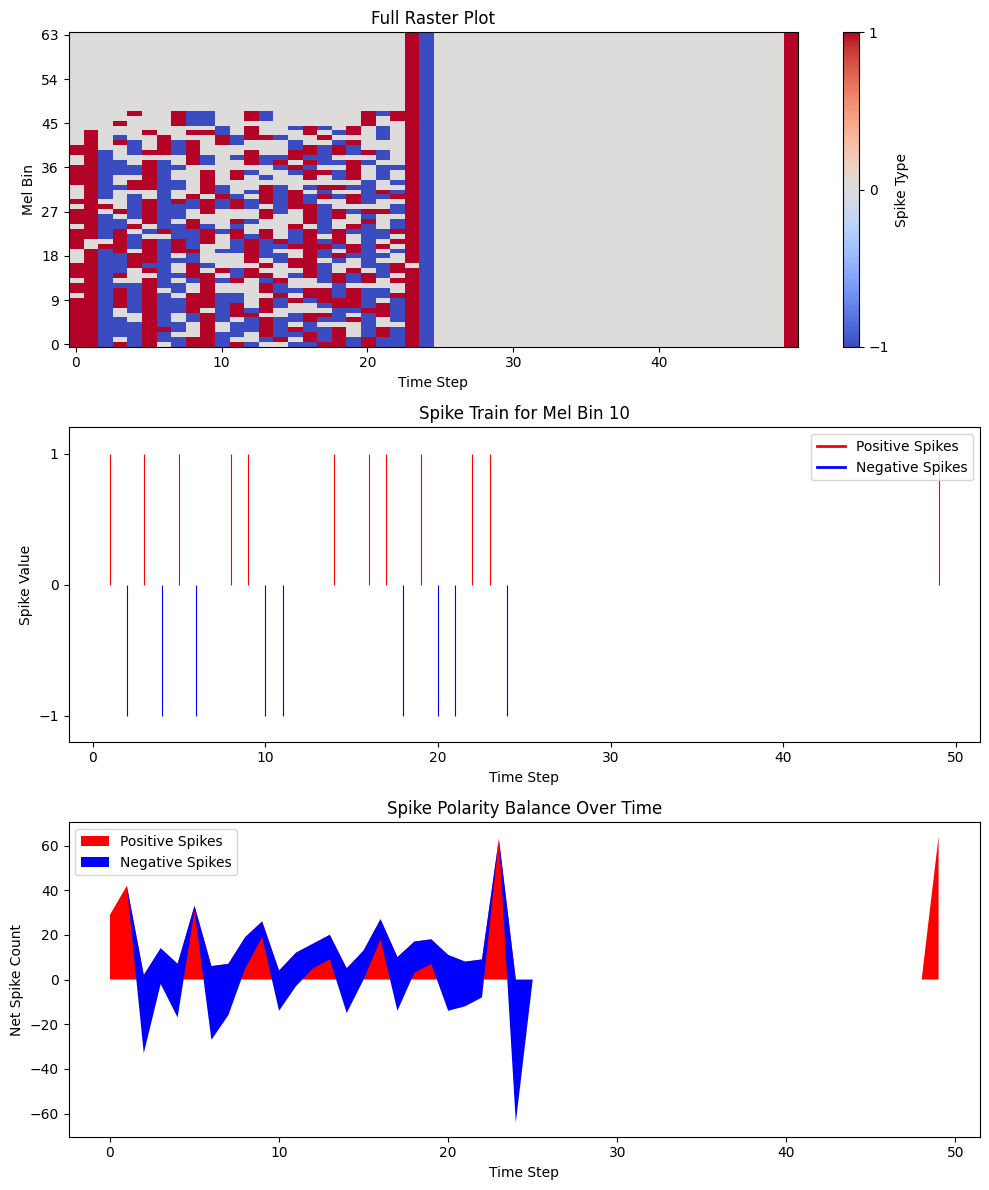

Class rooster


In [45]:
sample_idx = 0
visualize_spike_trains(X_batch, sample_idx=sample_idx, mel_bin=10)
print("Class", ESCLabels(y_batch[sample_idx].item()).name)

Identificazione dei frame silenziosi nei log-mel

In [46]:
def count_silent_frames(mel_list, silence_threshold_db=-70):
    silent_frame_counts = []
    for mel in tqdm(mel_list, desc="Analisi dei frame silenziosi"):
        # Conta i frame in cui tutti i valori sono inferiori alla soglia di silenzio
        silent_frames = np.all(mel < silence_threshold_db, axis=0)
        silent_frame_counts.append(np.sum(silent_frames))
    return silent_frame_counts

In [47]:
silent_counts_train = count_silent_frames(X_train_mel)
silent_counts_val = count_silent_frames(X_val_mel)
silent_counts_test = count_silent_frames(X_test_mel)

print(f"Media dei frame silenziosi nel training set: {np.mean(silent_counts_train):.2f}")
print(f"Media dei frame silenziosi nel validation set: {np.mean(silent_counts_val):.2f}")
print(f"Media dei frame silenziosi nel test set: {np.mean(silent_counts_test):.2f}")


Analisi dei frame silenziosi: 100%|██████████| 60/60 [00:00<00:00, 8097.11it/s]

Media dei frame silenziosi nel training set: 19.00
Media dei frame silenziosi nel validation set: 19.00
Media dei frame silenziosi nel test set: 19.00


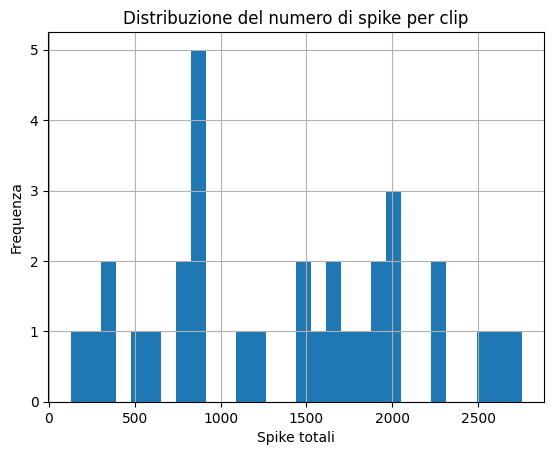

In [48]:
def count_spikes(spike_train):
    return spike_train.abs().sum(dim=[1, 2])  # somma spike su tempo e bande mel

spike_counts = count_spikes(X_batch)
plt.hist(spike_counts.cpu().numpy(), bins=30)
plt.title("Distribuzione del numero di spike per clip")
plt.xlabel("Spike totali")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()


## Moving Window

In [43]:
class MovingWindowDataset(Dataset):
  def __init__(self, X, y, window_length=10):
    """
      Moving Window encoding dataset for audio spectrograms.

      Args:
          X: Tensor of shape [num_samples, n_mels, time_steps, 1]
          y: Tensor of labels [num_samples]
          window_length: Size of the sliding window for calculating the base mean
    """
    self.X = X
    self.y = y
    self.window_length = window_length

  def __len__(self):
    return len(self.X)

  def _encode(self, signal):
    """
      Encode a signal using the Moving Window algorithm.

      Args:
          signal: 1D tensor to encode

      Returns:
          Encoded spike train with values {-1, 0, 1}
    """
    signal_np = signal.numpy()

    # Calculate variation and threshold
    variation = np.diff(signal_np, prepend=signal_np[0])
    threshold = np.mean(np.abs(variation))

    # Initialize spike array
    spikes = np.zeros_like(signal_np, dtype=np.int8)

    # Compute the moving window mean and apply thresholds
    for t in range(len(signal_np)):
        if t < self.window_length:
            base = np.mean(signal_np[: self.window_length])
        else:
            base = np.mean(signal_np[t - self.window_length : t])

        if signal_np[t] > base + threshold:
            spikes[t] = 1
        elif signal_np[t] < base - threshold:
            spikes[t] = -1

    return torch.from_numpy(spikes)

  def __getitem__(self, idx):
    x = self.X[idx].squeeze(-1)  # [n_mels, time_steps]
    y = self.y[idx]

    spike_train = torch.zeros(
        x.shape[1], x.shape[0], dtype=torch.int8
    )  # [time_steps, n_mels]

    for mel_idx in range(x.shape[0]):
      spike_train[:, mel_idx] = self._encode(x[mel_idx])

    return spike_train, y.long()

In [44]:

WINDOW_LENGTH = 50

mw_train_dataset = MovingWindowDataset(
    X_train, y_train,
    window_length=WINDOW_LENGTH
)

mw_val_dataset = MovingWindowDataset(
    X_val, y_val,
    window_length=WINDOW_LENGTH
)

mw_test_dataset = MovingWindowDataset(
    X_test, y_test,
    window_length=WINDOW_LENGTH
)

# Create dataloaders
mw_train_dataloader = DataLoader(
    dataset=mw_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

mw_val_dataloader = DataLoader(
    dataset=mw_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

mw_test_dataloader = DataLoader(
    dataset=mw_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

mw_x_batch, mw_y_batch = next(iter(mw_train_dataloader))

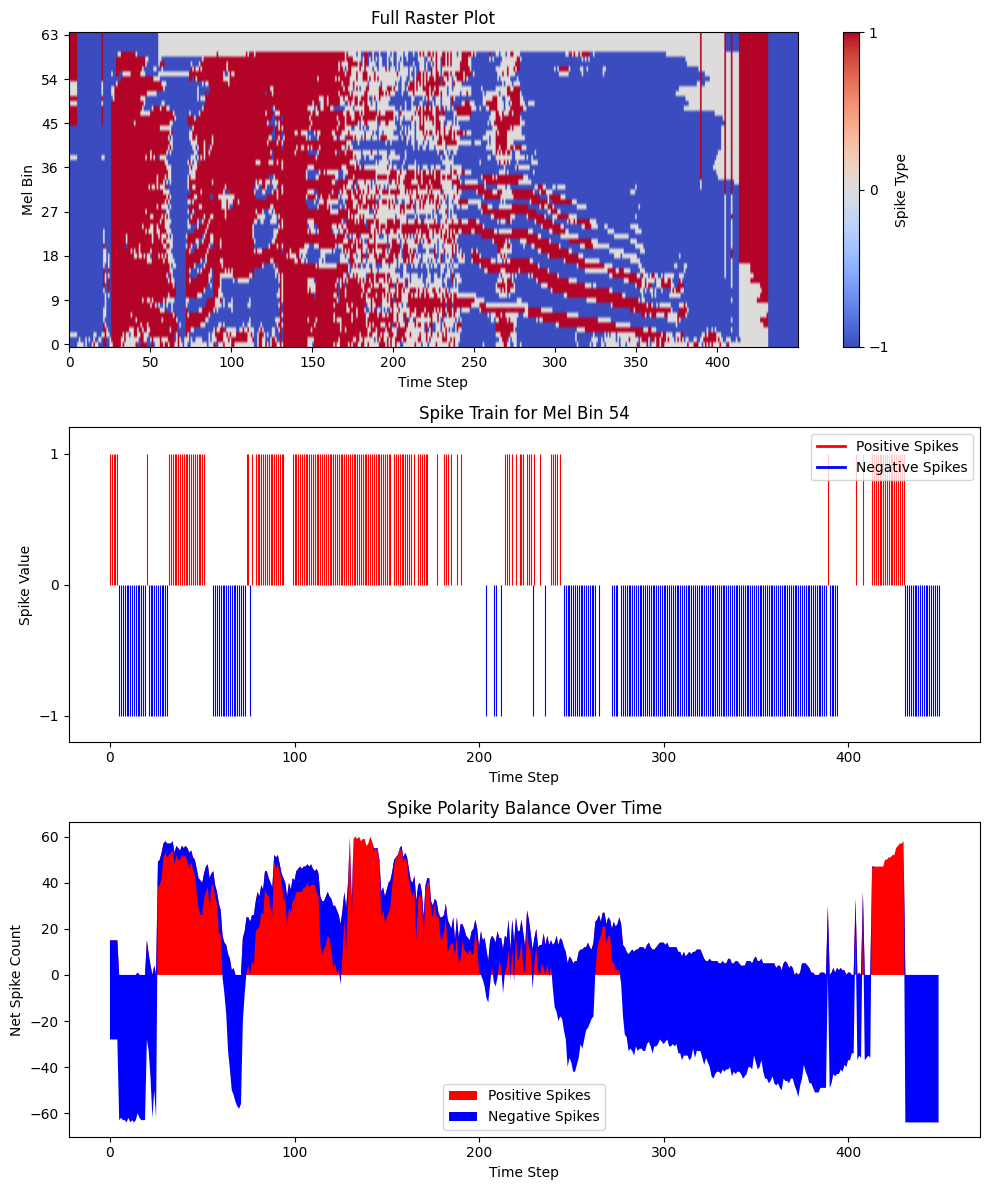

In [45]:
visualize_spike_trains(spike_tensor=mw_x_batch, sample_idx=0, mel_bin=54)

# SNN Modelling

A single batch of data has shape: \[batch_size, time_frames, n_mels\].

In [ ]:
class SNNClassifier(torch.nn.Module):
    def __init__(
        self,
        n_mels,
        hidden_sizes,
        num_classes,
        surr_grad,
        learn_thr=False,
        learn_beta=True,
    ):
        super(SNNClassifier, self).__init__()
        self.n_mels = n_mels
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # Layer 1: Input to first hidden layer
        self.fc1 = torch.nn.Linear(n_mels, hidden_sizes[0])
        self.lif_in = snn.Leaky(
            beta=torch.rand(hidden_sizes[0]),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 2: First hidden to second hidden layer
        self.fc2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.lif_hidden = snn.Leaky(
            beta=torch.rand(hidden_sizes[1]),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Output layer
        self.fc_out = torch.nn.Linear(hidden_sizes[1], num_classes)
        self.lif_out = snn.Leaky(
            beta=torch.rand(num_classes),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

    def forward(self, x):
      # Input shape: [batch_size, time_steps, n_mels]
      batch_size = x.shape[0]
      time_steps = x.shape[1]

      mem_1 = self.lif_in.init_leaky()
      mem_2 = self.lif_hidden.init_leaky()
      mem_o = self.lif_out.init_leaky()

      spk_rec = []
      mem_rec = []

      for step in range(time_steps):
        x_t = x[:, step, :]  # Shape: [batch_size, n_mels]

        cur1 = self.fc1(x_t)
        spk1, mem_1 = self.lif_in(cur1, mem_1)

        cur2 = self.fc2(spk1)
        spk2, mem_2 = self.lif_hidden(cur2, mem_2)

        cur_out = self.fc_out(spk2)
        spk_out, mem_o = self.lif_out(cur_out, mem_o)

        spk_rec.append(spk_out)
        mem_rec.append(mem_o)

      return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

## DeltaModulation Training

In [ ]:
n_mels = 64
hidden_sizes = [128, 64]
num_classes = 10

snn_classifier = SNNClassifier(
    n_mels=n_mels,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=False,
    learn_beta=True
).to(device)

summary(snn_classifier, input_size=(32, 1, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 8,320
├─Leaky: 1-2                             [32, 128]                 128
├─Linear: 1-3                            [32, 64]                  8,256
├─Leaky: 1-4                             [32, 64]                  64
├─Linear: 1-5                            [32, 10]                  650
├─Leaky: 1-6                             [32, 10]                  10
Total params: 17,428
Trainable params: 17,428
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.55
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.07
Estimated Total Size (MB): 0.18

In [ ]:
def train_fn(model, train_loader, valid_loader, accuracy, loss_fn, optimizer,
             epochs, patience, path, verbose=True, max_batches=None):
    """
    Optimized training function with:
    - Optional batch limiting (for quick testing)
    - Mixed precision training
    - Reduced GPU memory usage
    - Progress tracking
    """
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    counter = 0
    best_val_loss = float('inf')

    # Enable mixed precision training if available
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

    for epoch in tqdm(range(epochs), desc="Epochs"):
        start_time = time.time()

        # Training mode
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc="Train batches", leave=False, total=len(train_loader))):
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            optimizer.zero_grad(set_to_none=True)

            # Use mixed precision where available
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                spk_out, _ = model(X.float())
                acc = accuracy(spk_out, y)
                loss = loss_fn(spk_out, y)
                loss.backward()
                optimizer.step()

            train_acc += acc.item()
            train_loss += loss.item()

            # Free up memory
            del X, y, spk_out, loss, acc

        # Calculate average metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc_avg = train_acc / len(train_loader)
        train_loss_list.append(train_loss_avg)
        train_acc_list.append(train_acc_avg)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(valid_loader):
                X = X.squeeze().to(device)
                y = y.squeeze().long().to(device)

                # Forward pass with reduced memory usage
                if scaler:
                    with torch.cuda.amp.autocast():
                        spk_out, _ = model(X.float())
                        acc = accuracy(spk_out, y)
                        loss = loss_fn(spk_out, y)
                else:
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                val_acc += acc.item()
                val_loss += loss.item()

                # Free up memory
                del X, y, spk_out, loss, acc

        # Calculate validation metrics
        val_loss_avg = val_loss / len(valid_loader)
        val_acc_avg = val_acc / len(valid_loader)
        val_loss_list.append(val_loss_avg)
        val_acc_list.append(val_acc_avg)

        # Early stopping logic
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            counter = 0
            if path:
                #torch.save(model.state_dict(), path)
                pass
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered")
            break

        torch.cuda.empty_cache()
        end_time = time.time()

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - {int(end_time-start_time)}s - "
                  f"loss: {train_loss_avg:.4f} - acc: {train_acc_avg:.4f} - "
                  f"val_loss: {val_loss_avg:.4f} - val_acc: {val_acc_avg:.4f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [ ]:
num_epochs = 100
patience = 30
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.0001)


train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=delta_train_dataloader,
    valid_loader=delta_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

Train batches:   0%|          | 0/219 [00:00<?, ?it/s]<ipython-input-163-9e3f4ee869db>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches: 100%|██████████| 219/219 [00:56<00:00,  4.74it/s]
                                                                <ipython-input-163-9e3f4ee869db>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   1%|          | 1/100 [00:57<1:35:30, 57.89s/it]

Epoch 1/100 - 57s - loss: 9.0432 - acc: 0.1163 - val_loss: 3.2189 - val_acc: 0.1339



Epochs:   2%|▏         | 2/100 [01:56<1:35:05, 58.22s/it]

Epoch 2/100 - 58s - loss: 2.7572 - acc: 0.1228 - val_loss: 2.8525 - val_acc: 0.1027



Epochs:   3%|▎         | 3/100 [02:54<1:33:48, 58.03s/it]

Epoch 3/100 - 57s - loss: 2.4751 - acc: 0.1203 - val_loss: 2.5104 - val_acc: 0.1116



Epochs:   4%|▍         | 4/100 [03:53<1:33:32, 58.46s/it]

Epoch 4/100 - 59s - loss: 2.3975 - acc: 0.1211 - val_loss: 2.4601 - val_acc: 0.1540



Epochs:   5%|▌         | 5/100 [04:53<1:33:25, 59.01s/it]

Epoch 5/100 - 59s - loss: 2.3842 - acc: 0.1314 - val_loss: 2.4371 - val_acc: 0.1652



Epochs:   6%|▌         | 6/100 [05:52<1:32:19, 58.94s/it]

Epoch 6/100 - 58s - loss: 2.3300 - acc: 0.1470 - val_loss: 2.2980 - val_acc: 0.0982



Epochs:   7%|▋         | 7/100 [06:51<1:31:30, 59.03s/it]

Epoch 7/100 - 59s - loss: 2.3146 - acc: 0.1586 - val_loss: 2.3604 - val_acc: 0.1339



Epochs:   8%|▊         | 8/100 [07:51<1:31:02, 59.37s/it]

Epoch 8/100 - 60s - loss: 2.3041 - acc: 0.1649 - val_loss: 2.4019 - val_acc: 0.1339



Epochs:   9%|▉         | 9/100 [08:52<1:30:56, 59.96s/it]

Epoch 9/100 - 61s - loss: 2.2691 - acc: 0.1807 - val_loss: 2.1959 - val_acc: 0.1964



Epochs:  10%|█         | 10/100 [09:57<1:32:11, 61.46s/it]

Epoch 10/100 - 64s - loss: 2.2628 - acc: 0.1809 - val_loss: 2.2027 - val_acc: 0.2321



Epochs:  11%|█         | 11/100 [10:56<1:30:02, 60.71s/it]

Epoch 11/100 - 58s - loss: 2.2285 - acc: 0.1913 - val_loss: 2.0592 - val_acc: 0.2522



Epochs:  12%|█▏        | 12/100 [11:56<1:28:52, 60.60s/it]

Epoch 12/100 - 60s - loss: 2.2060 - acc: 0.2058 - val_loss: 2.3140 - val_acc: 0.1987



Epochs:  13%|█▎        | 13/100 [12:56<1:27:20, 60.23s/it]

Epoch 13/100 - 59s - loss: 2.1913 - acc: 0.2078 - val_loss: 2.1198 - val_acc: 0.1830



Epochs:  14%|█▍        | 14/100 [13:55<1:25:53, 59.92s/it]

Epoch 14/100 - 59s - loss: 2.1833 - acc: 0.2100 - val_loss: 2.0565 - val_acc: 0.2969



Epochs:  15%|█▌        | 15/100 [14:55<1:25:02, 60.03s/it]

Epoch 15/100 - 60s - loss: 2.1784 - acc: 0.2199 - val_loss: 2.0868 - val_acc: 0.2121



Train batches:  71%|███████   | 155/219 [00:41<00:15,  4.05it/s]

In [ ]:
print(train_loss[-1], train_acc[-1] * 100, val_loss[-1], val_acc[-1] * 100)

1.699834751756224 41.956811263318116 2.0710991621017456 38.16964285714286


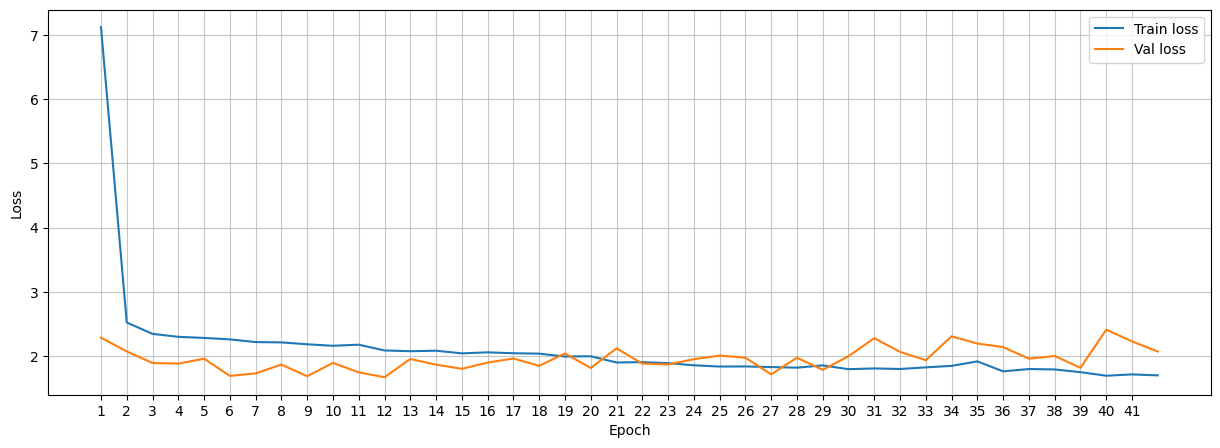

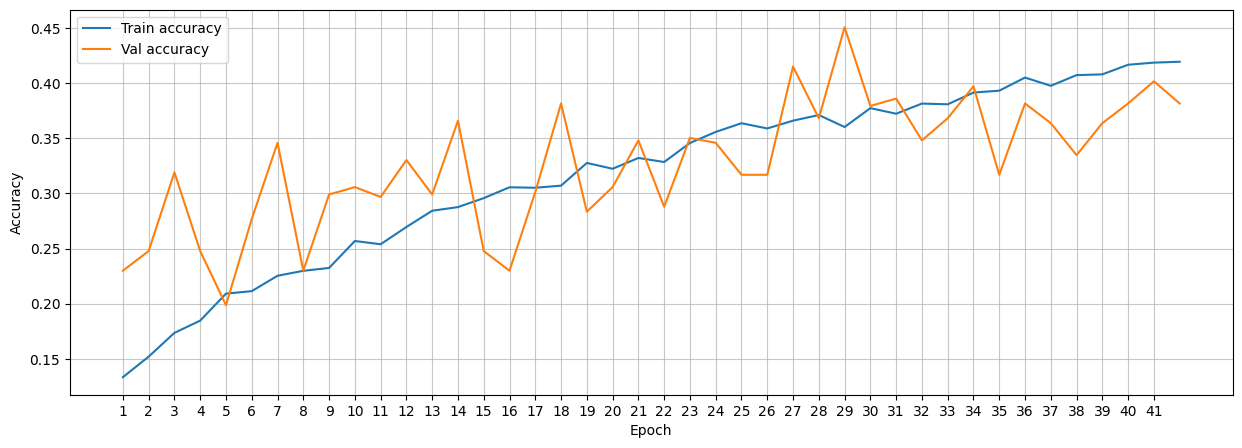

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

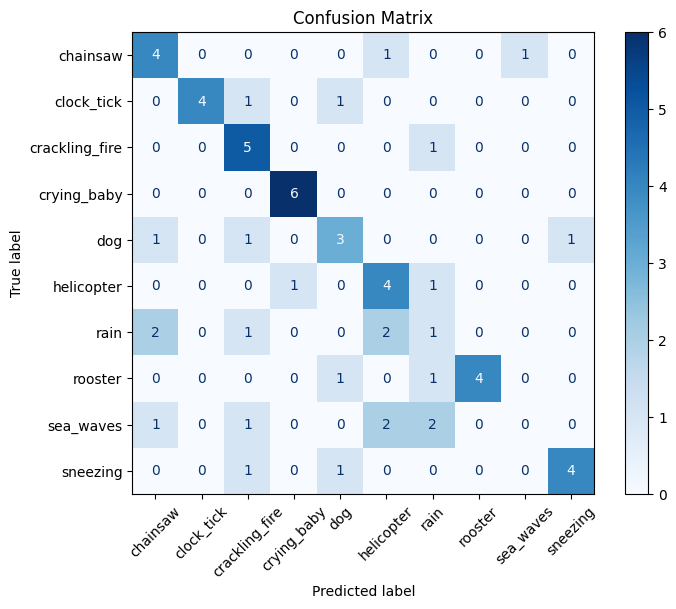

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            spk_out, _ = model(X.float())
            spk_sum = spk_out.sum(dim=0)  # shape: [batch_size, num_classes]
            preds = torch.argmax(spk_sum, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]

evaluate_and_plot_confusion_matrix(snn_classifier, delta_test_dataloader, class_names)

## Moving Window Training

In [ ]:
patience = 40
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=mw_train_dataloader,
    valid_loader=mw_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

NameError: name 'snn_classifier' is not defined

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
evaluate_and_plot_confusion_matrix(snn_classifier, mw_test_dataloader, class_names)

### DEEP SNN

In [68]:
class SNNClassifier(torch.nn.Module):
    def __init__(
        self,
        n_mels,
        hidden_sizes,
        num_classes,
        surr_grad,
        learn_thr=False,
        learn_beta=True,
    ):
        super(SNNClassifier, self).__init__()
        self.n_mels = n_mels
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # Layer 1: Input to first hidden layer
        self.fc1 = torch.nn.Conv1d(n_mels, 256, kernel_size=3, padding=1)
        self.lif_in = snn.Leaky(
            beta=torch.rand(hidden_sizes[0]),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 2: First hidden to second hidden layer
        self.fc2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.lif_hidden = snn.Leaky(
            beta=torch.rand(hidden_sizes[1]),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        #Layer 3: Second hidden to third hidden layer
        self.fc3 = torch.nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.lif_hidden2 = snn.Leaky(
            beta=torch.rand(hidden_sizes[2]),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Output layer
        self.fc_out = torch.nn.Linear(hidden_sizes[2], num_classes)
        self.lif_out = snn.Leaky(
            beta=torch.rand(num_classes),
            threshold=0.05,
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )


#aggiungo spike rate decoding

    def forward(self, x):
      # Input shape: [batch_size, time_steps, n_mels]
      x = x.permute(0, 2, 1)
      x = self.fc1(x)
      x = x.permute(0, 2, 1)

      batch_size = x.shape[0]
      time_steps = x.shape[1]

      mem_1 = self.lif_in.init_leaky()
      mem_2 = self.lif_hidden.init_leaky()
      mem_3 = self.lif_hidden2.init_leaky()
      mem_o = self.lif_out.init_leaky()

      spk_rec = []
      mem_rec = []

      for step in range(time_steps):
        x_t = x[:, step, :]  # Shape: [batch_size, n_mels]

        cur1 = x_t
        spk1, mem_1 = self.lif_in(cur1, mem_1)

        cur2 = self.fc2(spk1)
        spk2, mem_2 = self.lif_hidden(cur2, mem_2)

        cur3 = self.fc3(spk2)
        spk3, mem_3 = self.lif_hidden2(cur3, mem_3)

        cur_out = self.fc_out(spk3)
        spk_out, mem_o = self.lif_out(cur_out, mem_o)

        spk_rec.append(spk_out)
        mem_rec.append(mem_o)

      return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

In [69]:
n_mels = 64
hidden_sizes = [256, 256, 128]
num_classes = 10

snn_classifier = SNNClassifier(
    n_mels=n_mels,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=False,
    learn_beta=True
).to(device)

summary(snn_classifier, input_size=(32, 1, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Conv1d: 1-1                            [32, 256, 1]              49,408
├─Leaky: 1-2                             [32, 256]                 256
├─Linear: 1-3                            [32, 256]                 65,792
├─Leaky: 1-4                             [32, 256]                 256
├─Linear: 1-5                            [32, 128]                 32,896
├─Leaky: 1-6                             [32, 128]                 128
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  10
Total params: 150,036
Trainable params: 150,036
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.78
Input size (MB): 0.01
Forward/backward pass size (MB): 0.33
Params size (MB): 0.60
Estimated Total Size (MB): 0.94

In [70]:
def train_fn(model, train_loader, valid_loader, accuracy, loss_fn, optimizer,
             epochs, patience, path, verbose=True, max_batches=None):
    """
    Optimized training function with:
    - Optional batch limiting (for quick testing)
    - Mixed precision training
    - Reduced GPU memory usage
    - Progress tracking
    """
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    counter = 0
    best_val_loss = float('inf')

    # Enable mixed precision training if available
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

    for epoch in tqdm(range(epochs), desc="Epochs"):
        start_time = time.time()

        # Training mode
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc="Train batches", leave=False, total=len(train_loader))):
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            optimizer.zero_grad(set_to_none=True)

            # Use mixed precision where available
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                spk_out, _ = model(X.float())
                acc = accuracy(spk_out, y)
                loss = loss_fn(spk_out, y)
                loss.backward()
                optimizer.step()

            train_acc += acc.item()
            train_loss += loss.item()

            # Free up memory
            del X, y, spk_out, loss, acc

        # Calculate average metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc_avg = train_acc / len(train_loader)
        train_loss_list.append(train_loss_avg)
        train_acc_list.append(train_acc_avg)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(valid_loader):
                X = X.squeeze().to(device)
                y = y.squeeze().long().to(device)

                # Forward pass with reduced memory usage
                if scaler:
                    with torch.cuda.amp.autocast():
                        spk_out, _ = model(X.float())
                        acc = accuracy(spk_out, y)
                        loss = loss_fn(spk_out, y)
                else:
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                val_acc += acc.item()
                val_loss += loss.item()

                # Free up memory
                del X, y, spk_out, loss, acc

        # Calculate validation metrics
        val_loss_avg = val_loss / len(valid_loader)
        val_acc_avg = val_acc / len(valid_loader)
        val_loss_list.append(val_loss_avg)
        val_acc_list.append(val_acc_avg)

        # Early stopping logic
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            counter = 0
            if path:
                #torch.save(model.state_dict(), path)
                pass
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered")
            break

        torch.cuda.empty_cache()
        end_time = time.time()

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - {int(end_time-start_time)}s - "
                  f"loss: {train_loss_avg:.4f} - acc: {train_acc_avg:.4f} - "
                  f"val_loss: {val_loss_avg:.4f} - val_acc: {val_acc_avg:.4f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [ ]:
num_epochs = 100
patience = 30
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.0001)


train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=delta_train_dataloader,
    valid_loader=delta_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

Train batches:  29%|██▉       | 63/219 [00:26<00:55,  2.81it/s]
